In [3]:
# Importing libraries


import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Initital configurations
SEED = 1234

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

# Set seeds for reproducibility
set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
    

print(device)

cuda


In [2]:
torch.cuda.is_available()

True

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
path_to_excel_file_of_normal = ''
path_to_excel_file_of_anormal = ''

path_to_folder_of_normal = '' #put * at the end. So that all files will be taken
path_to_folder_of_anormal = '' #put * at the end. So that all files will be taken

path_where_you_want_to_save_the_model = ''
the_name_you_want_to_give_to_the_model = '' #add the .pth extension 

In [4]:
normal_df = pd.read_excel(path_to_excel_file_of_normal)
anormal_df = pd.read_excel(path_to_excel_file_of_anormal)

print("-------------------Dataset------------------")
print("Images Normal: ",len(normal_df))
print("Images Anormal: ",len(anormal_df))

-------------------Dataset------------------
Total Normal CXR Images:  332
Total Tuberculosis CXR Images:  19


In [4]:
import glob
anormal = glob.glob(path_to_folder_of_anormal)
normal = glob.glob(path_to_folder_of_normal)

# Splitting in 70:15:15 ratio 
train_path = normal[:249] + anormal[:14]
val_path = normal[249:299] + anormal[14:17]
test_path = normal[299:] + anormal[17:]

# shuffling 
random.shuffle(train_path)
random.shuffle(val_path)
random.shuffle(test_path)

print("-------------------Dataset------------------")
print("Total train Images: ",len(train_path))
print("Total validation Images: ",len(val_path))
print("Total test Images: ",len(test_path))

-------------------Dataset------------------
Total train Images:  263
Total validation Images:  53
Total test Images:  42


In [6]:
print(train_path)
print(val_path)
print(test_path)

['K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0240.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0080.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0015.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0100.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0152.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0036.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0204.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0199.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0085.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0218.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0221.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0038.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0062.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0216.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\0243.JPEG', 'K:/Docs/stage_ingenieur/models/datas/cxrs/normal\\020

In [7]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'others': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
""" 
label 0 = normal
label 1 = no normal

After that, we used this class to create datasets for train, validation, and test data using specific 
transforms for each and created DataLoader objects for each dataset with batch size of 32.

"""
class CXR_Dataset(Dataset):
    def __init__(self, images, transform=None):
        self.img_paths = images
        self.img_labels = [0 if "normal" in img else 1 for img in self.img_paths]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get the image path and label for the specified index
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        # load the image from the path
        image = Image.open(img_path)
        image = image.convert("RGB")

        # apply transform
        if self.transform:
            image = self.transform(image)
        
        # return the image and label as a tuple
        return image, label

# Dataset for train, valid and test
train_data = CXR_Dataset(train_path, transform = data_transforms["train"]) 
valid_data = CXR_Dataset(val_path, transform = data_transforms["others"]) 
test_data = CXR_Dataset(test_path, transform = data_transforms["others"]) 

# Dataloader for train, valid and test
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

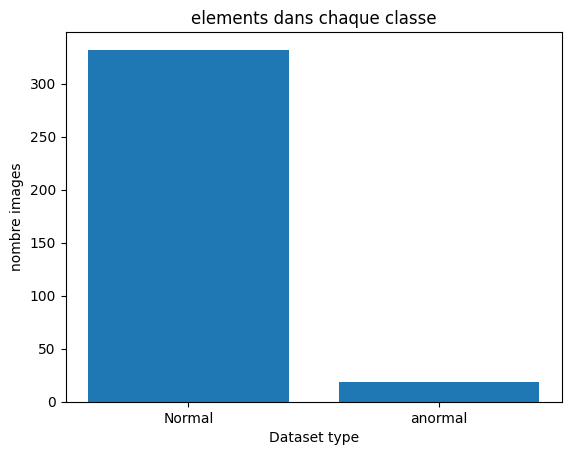

In [12]:
import matplotlib.pyplot as plt
normal_size = len(normal_df)
anormal_size = len(anormal_df)
sizes = [normal_size, anormal_size]

plt.bar(['Normal', 'Anormal'], sizes)

plt.xlabel('labels')
plt.ylabel('nombre images')
plt.title('elements dans chaque classe')

plt.show()

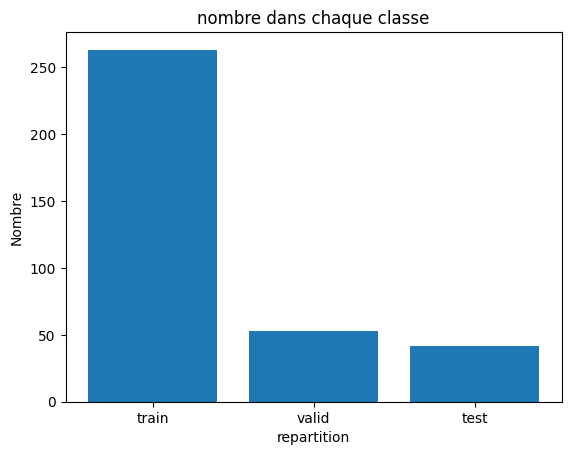

In [13]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data) 

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'validation', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('repartition')
plt.ylabel('Nombre')
plt.title('nombre dans chaque classe')

# Show the plot
plt.show()

In [11]:
print(train_dataloader)

tensor([0])


IndexError: index 1 is out of bounds for dimension 0 with size 1

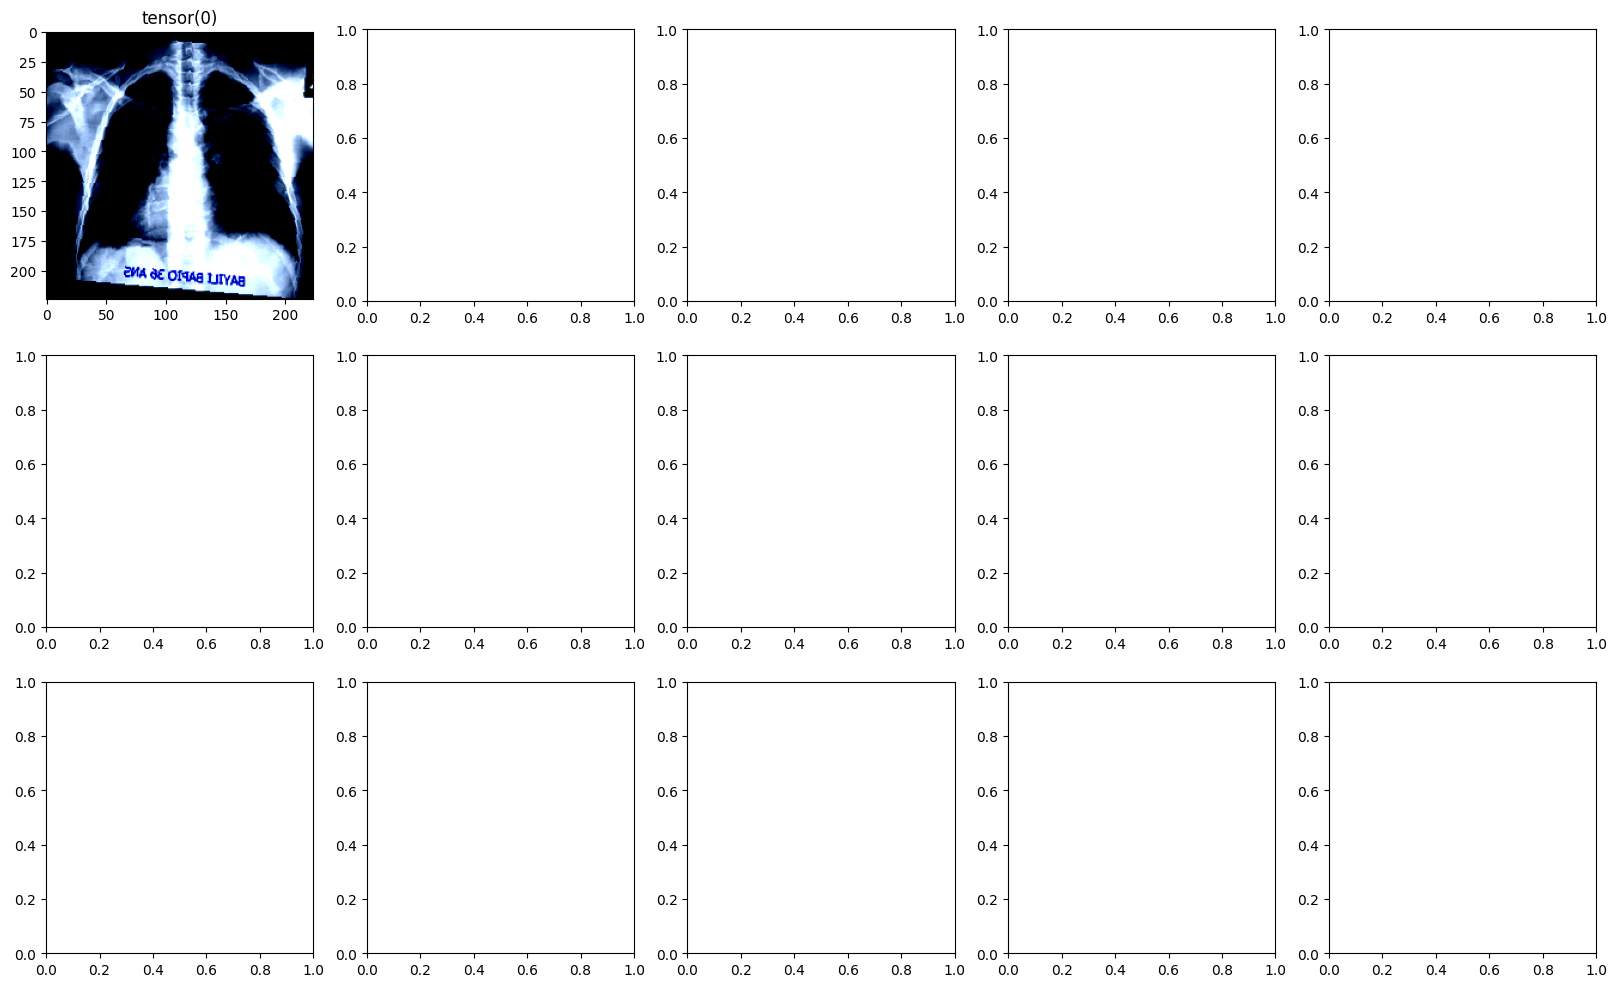

In [44]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))
print(labels)

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]
    
    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    
    # Set the title of the subplot to the label
    ax.set_title(label)

# Show the plot
plt.show()

In [47]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet

#model architecture
class CXR_DenseNetModel(nn.Module):
  """DenseNet121 pretrained model definition."""
  def __init__(self, num_classes):
      super(CXR_DenseNetModel, self).__init__()

      self.model = torchvision.models.densenet121(pretrained=True)

      # Freeze the model's parameters
      for param in self.model.parameters():
          param.requires_grad = False

      # Replace the last linear layer of the model
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Sequential( 
          nn.Linear(in_features, in_features // 2),
          nn.Dropout(0.5),
          nn.Linear(in_features // 2, in_features // 4),
          # nn.Dropout(0.5),
          nn.Linear(in_features // 4, in_features // 8),
          nn.Dropout(0.25),
          nn.Linear(in_features // 8, num_classes),
      )

  def forward(self, x):
      return self.model(x)

model = CXR_DenseNetModel(num_classes=2)

# set device
model = model.to(device) 
model


CXR_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [48]:
# calculating weights for each classes
def class_weight(x,total):
  return 1 - (x/total)

total = 249 + 14
class_weights = torch.tensor([class_weight(249,total),class_weight(14,total)])
print(class_weights)

tensor([0.0532, 0.9468])


In [50]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss(weight = class_weights.to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [52]:
from tqdm import tqdm
train_losses = []
valid_losses = []
train_acc = []
valid_acc=[]
# Define a function for the training loop
def train(model, loss_fn, optimizer, num_epochs):

    for epoch in tqdm(range(num_epochs)):

        # Training
        # Set the model to training mode
        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0

        # Loop through the training dataloader
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

        # Validation
        # Set the model to evalutaion mode
        model.eval()

        valid_size = 0
        valid_loss = 0.0
        valid_accuracy = 0.0

        # Loop through the validing dataloader
        for batch_idx, (images, labels) in enumerate(valid_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            valid_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            valid_loss += loss.item() * images.size(0)
            valid_size += images.size(0)

        # Print training and validation statistics
        train_loss = train_loss / train_size
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / train_size
        train_acc.append(train_accuracy)

        valid_loss = valid_loss / valid_size
        valid_losses.append(valid_loss)

        valid_accuracy = valid_accuracy / valid_size
        valid_acc.append(valid_accuracy)

        
        print(f"\nTrain Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f}, Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_accuracy:.2f}")

# Train the model
train(model, loss_fn, optimizer, num_epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:28<11:24, 28.54s/it]


Train Loss: 0.554,Train Accuracy: 0.935, Valid Loss: 0.360, Valid Accuracy: 0.94


  8%|▊         | 2/25 [00:45<08:23, 21.89s/it]


Train Loss: 0.193,Train Accuracy: 0.935, Valid Loss: 0.170, Valid Accuracy: 0.94


 12%|█▏        | 3/25 [01:08<08:14, 22.47s/it]


Train Loss: 0.170,Train Accuracy: 0.947, Valid Loss: 0.124, Valid Accuracy: 0.94


 16%|█▌        | 4/25 [01:31<07:51, 22.46s/it]


Train Loss: 0.147,Train Accuracy: 0.947, Valid Loss: 0.131, Valid Accuracy: 0.94


 20%|██        | 5/25 [01:53<07:28, 22.41s/it]


Train Loss: 0.156,Train Accuracy: 0.939, Valid Loss: 0.133, Valid Accuracy: 0.94


 24%|██▍       | 6/25 [02:16<07:08, 22.54s/it]


Train Loss: 0.161,Train Accuracy: 0.939, Valid Loss: 0.146, Valid Accuracy: 0.94


 28%|██▊       | 7/25 [02:39<06:46, 22.56s/it]


Train Loss: 0.144,Train Accuracy: 0.947, Valid Loss: 0.130, Valid Accuracy: 0.94


 32%|███▏      | 8/25 [03:01<06:24, 22.61s/it]


Train Loss: 0.175,Train Accuracy: 0.939, Valid Loss: 0.169, Valid Accuracy: 0.94


 36%|███▌      | 9/25 [03:24<06:00, 22.55s/it]


Train Loss: 0.159,Train Accuracy: 0.947, Valid Loss: 0.138, Valid Accuracy: 0.94


 40%|████      | 10/25 [03:46<05:37, 22.50s/it]


Train Loss: 0.162,Train Accuracy: 0.947, Valid Loss: 0.119, Valid Accuracy: 0.94


 44%|████▍     | 11/25 [04:08<05:14, 22.44s/it]


Train Loss: 0.154,Train Accuracy: 0.947, Valid Loss: 0.151, Valid Accuracy: 0.94


 48%|████▊     | 12/25 [04:31<04:51, 22.42s/it]


Train Loss: 0.132,Train Accuracy: 0.947, Valid Loss: 0.114, Valid Accuracy: 0.94


 52%|█████▏    | 13/25 [04:53<04:28, 22.36s/it]


Train Loss: 0.205,Train Accuracy: 0.935, Valid Loss: 0.167, Valid Accuracy: 0.94


 56%|█████▌    | 14/25 [05:15<04:06, 22.37s/it]


Train Loss: 0.147,Train Accuracy: 0.939, Valid Loss: 0.117, Valid Accuracy: 0.94


 60%|██████    | 15/25 [05:38<03:43, 22.39s/it]


Train Loss: 0.200,Train Accuracy: 0.928, Valid Loss: 0.178, Valid Accuracy: 0.92


 64%|██████▍   | 16/25 [06:01<03:23, 22.61s/it]


Train Loss: 0.193,Train Accuracy: 0.909, Valid Loss: 0.282, Valid Accuracy: 0.92


 68%|██████▊   | 17/25 [06:23<03:00, 22.59s/it]


Train Loss: 0.219,Train Accuracy: 0.916, Valid Loss: 0.033, Valid Accuracy: 0.98


 72%|███████▏  | 18/25 [06:46<02:37, 22.53s/it]


Train Loss: 0.403,Train Accuracy: 0.901, Valid Loss: 0.327, Valid Accuracy: 0.92


 76%|███████▌  | 19/25 [07:08<02:15, 22.53s/it]


Train Loss: 0.224,Train Accuracy: 0.909, Valid Loss: 0.051, Valid Accuracy: 0.96


 80%|████████  | 20/25 [07:31<01:52, 22.60s/it]


Train Loss: 0.166,Train Accuracy: 0.935, Valid Loss: 0.071, Valid Accuracy: 0.98


 84%|████████▍ | 21/25 [07:54<01:30, 22.58s/it]


Train Loss: 0.189,Train Accuracy: 0.935, Valid Loss: 0.083, Valid Accuracy: 0.98


 88%|████████▊ | 22/25 [08:16<01:07, 22.51s/it]


Train Loss: 0.184,Train Accuracy: 0.939, Valid Loss: 0.107, Valid Accuracy: 0.94


 92%|█████████▏| 23/25 [08:38<00:44, 22.48s/it]


Train Loss: 0.158,Train Accuracy: 0.939, Valid Loss: 0.031, Valid Accuracy: 0.98


 96%|█████████▌| 24/25 [09:01<00:22, 22.46s/it]


Train Loss: 0.192,Train Accuracy: 0.939, Valid Loss: 0.066, Valid Accuracy: 0.96


100%|██████████| 25/25 [09:23<00:00, 22.56s/it]


Train Loss: 0.264,Train Accuracy: 0.909, Valid Loss: 0.123, Valid Accuracy: 0.94


In [ ]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

In [ ]:
# plot train and test acc
train_acc_np= np.array([x.cpu().numpy() for x in train_acc])
valid_acc_np= np.array([x.cpu().numpy() for x in valid_acc])

plt.plot(train_acc_np, label='train accuracy')
plt.plot(valid_acc_np, label='validation accuracy')
plt.legend()
plt.show()

In [53]:
# Evaluation on test set
y_true = []
y_hat = []

test_size = 0
test_loss = 0.0
test_accuracy = 0.0
# Loop through the testing dataloader
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, F.one_hot(labels,2).float())

    # Compute accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

    y_true.extend(labels.detach().cpu().numpy().tolist())
    y_hat.extend(preds.detach().cpu().numpy().tolist())

    # Backward pass
    loss.backward()
    optimizer.step()

    test_loss += loss.item() * images.size(0)
    test_size += images.size(0)

In [55]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score
from mlxtend.plotting import plot_confusion_matrix

metrics_acc = BinaryAccuracy()
metric_auroc = BinaryAUROC(thresholds=None)
metric_f1 = BinaryF1Score()

target = torch.tensor(y_true)
preds = torch.tensor(y_hat)

# Accuracy
acc = metrics_acc(preds, target)

# AUROC
auroc = metric_auroc(preds, target)

# F1 Score
f1 = metric_f1(preds, target)

print("Test Accuracy: ", acc)
print("Test AUROC: ", auroc)
print("Test F1: ", f1)

Test Accuracy:  tensor(0.9429)
Test AUROC:  tensor(0.5000)
Test F1:  tensor(0.)


In [59]:
# Classification Report

from sklearn.metrics import classification_report
target_names = ['normal', 'anormal']
print(classification_report(y_true, y_hat, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.94      1.00      0.97        33
     anormal       0.00      0.00      0.00         2

    accuracy                           0.94        35
   macro avg       0.47      0.50      0.49        35
weighted avg       0.89      0.94      0.92        35



k:\Docs\stage_ingenieur\models\classification\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
k:\Docs\stage_ingenieur\models\classification\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
k:\Docs\stage_ingenieur\models\classification\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [57]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important: 
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_true, y_hat)

conf_matrix

array([[33,  0],
       [ 2,  0]], dtype=int64)

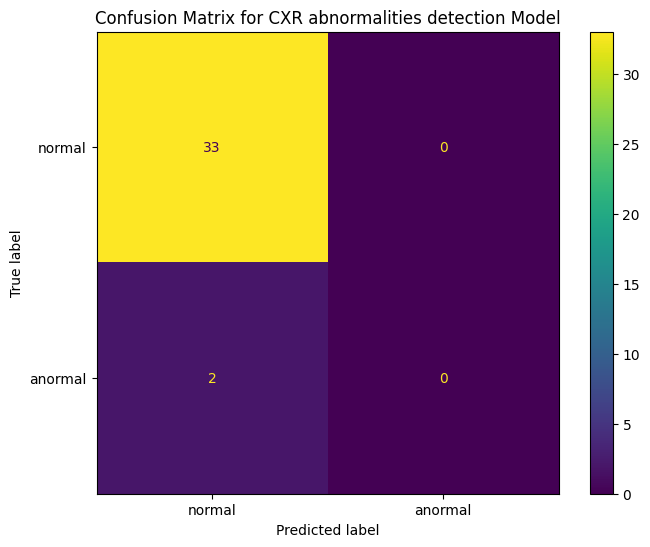

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['normal', 'anormal'])

# set the plot title using the axes object
ax.set(title='Confusion Matrix for CXR abnormalities detection Model')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

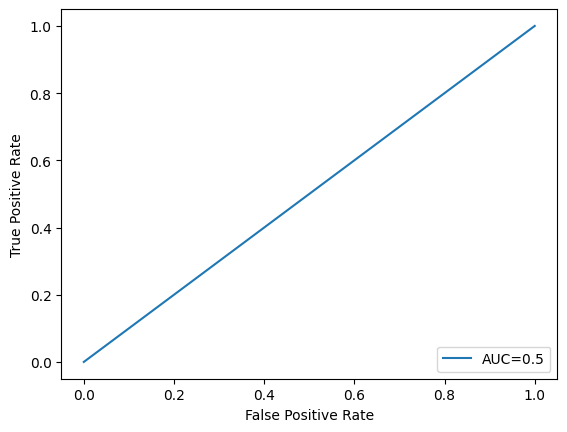

In [61]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_true,  y_hat)
auc = metrics.roc_auc_score(y_true, y_hat)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [62]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path(path_where_you_want_to_save_the_model)
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# create model save
MODEL_NAME = the_name_you_want_to_give_to_the_model
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME



# save the entire model
print(f'saving the entire model to :{MODEL_SAVE_PATH}')
torch.save(model, MODEL_SAVE_PATH)

saving the entire model to :K:\Docs\stage_ingenieur\models\classification\model_classification_densenet_with_data_augmentation.pth


In [65]:
# loading model
PATH = MODEL_SAVE_PATH
model = torch.load(PATH,map_location=torch.device('cpu'))

In [67]:
# saving the model in onnx format
import torch.onnx 

 # set the model to inference mode
model.eval()

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model,
                 x,
                 MODEL_SAVE_PATH+".onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )